In [4]:
!pip install numpy matplotlib imageio

Generating an Archimedean spiral with 8 revolutions...
Start Radius (a): 0
Tightness Factor (b): 1


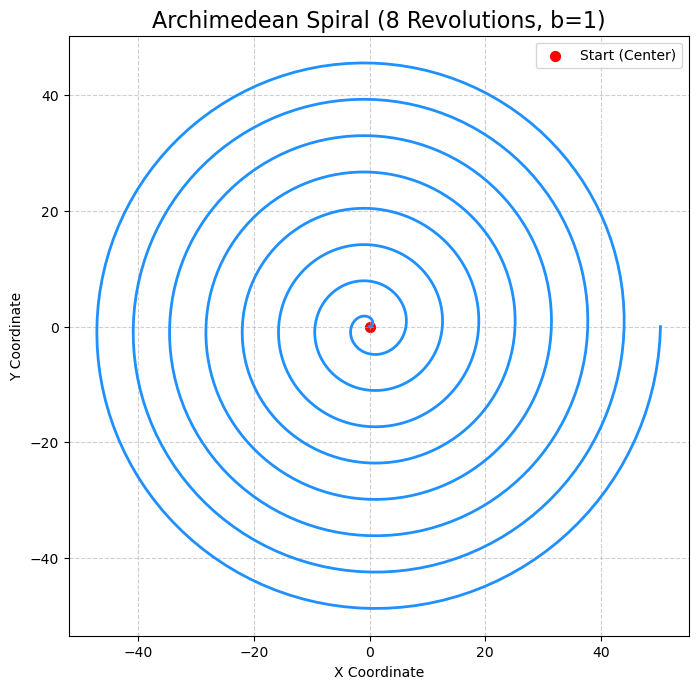


Spiral coordinates generated and plotted successfully.
Total points generated: 1000


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_archimedean_spiral(a, b, num_points=1000, revolutions=5):
    """
    Generates x and y coordinates for an Archimedean spiral.

    The equation for an Archimedean spiral in polar coordinates is:
        r = a + b * theta

    - 'a' determines the starting radius (usually 0 for a center-start).
    - 'b' determines the distance between the arms of the spiral (tightness).
    - 'theta' is the angle (in radians).
    """

    # 1. Generate angle values (theta)
    # We go from 0 up to 2 * pi * revolutions to complete the spiral turns.
    max_theta = 2 * np.pi * revolutions
    theta = np.linspace(0, max_theta, num_points)

    # 2. Calculate the radius (r) for each angle
    # The radius increases linearly with the angle, causing the spiral to widen.
    r = a + b * theta

    # 3. Convert polar coordinates (r, theta) to Cartesian coordinates (x, y)
    x = r * np.cos(theta)
    y = r * np.sin(theta)

    return x, y

def plot_spiral(x, y, title):
    """
    Plots the generated spiral coordinates using matplotlib.
    """
    plt.figure(figsize=(8, 8))
    plt.plot(x, y, color='dodgerblue', linewidth=2)
    plt.scatter(x[0], y[0], color='red', s=50, label='Start (Center)') # Mark the start point
    plt.title(title, fontsize=16)
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.gca().set_aspect('equal', adjustable='box') # Ensures the spiral isn't distorted
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # --- Spiral Parameters ---
    a = 0  # Start radius (0 means it starts exactly at the center [0,0])
    b = 1  # Tightness factor: Larger 'b' means the arms are farther apart
    revolutions = 8 # Number of turns the spiral completes

    print(f"Generating an Archimedean spiral with {revolutions} revolutions...")
    print(f"Start Radius (a): {a}")
    print(f"Tightness Factor (b): {b}")

    # Generate the coordinates
    x_coords, y_coords = generate_archimedean_spiral(a, b, revolutions=revolutions)

    # Plot the result
    plot_spiral(x_coords, y_coords, f'Archimedean Spiral ({revolutions} Revolutions, b={b})')

    print("\nSpiral coordinates generated and plotted successfully.")
    print(f"Total points generated: {len(x_coords)}")

    # You can access the coordinates like this:
    # print("First few X coordinates:", x_coords[:5])
    # print("First few Y coordinates:", y_coords[:5])

In [8]:
import numpy as np
# --- FIX 1: Explicitly set the Matplotlib backend to Agg for robust frame generation ---
# This resolves the 'AttributeError: ... has no attribute 'tostring_rgb'' in non-interactive environments.
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
# -----------------------------------------------------------------------------------------
from matplotlib.animation import FuncAnimation
import imageio.v3 as iio

# --- Setup ---
# Known locations of the first few non-trivial zeros of the Riemann zeta function
# (the values of 't' for which zeta(1/2 + it) = 0)
KNOWN_ZEROS_T = [14.1347, 21.0220, 25.0109, 30.4249]
T_MAX = 40  # Upper limit for the imaginary part 't'

# --- 1. Simulation Function ---

def simulated_magnitude(t):
    """
    A simplified function that dips sharply near the known zeros to visually
    represent the magnitude |zeta(1/2 + it)| hitting zero on the critical line.
    
    This is not the true zeta function, but an illustrative proxy.
    """
    
    # Base increasing magnitude (simulating a general trend)
    base = 0.5 + t / 15.0
    
    # Create dips (zeros) using a Gaussian function near known zero locations
    dips = np.zeros_like(t, dtype=float)
    for t_zero in KNOWN_ZEROS_T:
        # Subtract a sharp Gaussian centered at each zero location
        dips -= 5.0 * np.exp(-((t - t_zero) ** 2) / 0.5)
        
    # Ensure the result is non-negative (since it represents magnitude)
    result = base + dips
    return np.maximum(result, 0.0)

# --- 2. Animation Setup ---

# Create the data points
t_values = np.linspace(0.01, T_MAX, 500)
magnitude_values = simulated_magnitude(t_values)

# --- 3. GIF Generation Function ---

def create_riemann_gif(filename="riemann_hypothesis_critical_line.gif"):
    """
    Generates the frames and saves them as a GIF file.
    """
    print("Starting GIF generation...")
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.style.use('dark_background')
    
    # Set up the static plot elements
    ax.plot(t_values, magnitude_values, color='#4CAF50', linewidth=3, label='$|\zeta(1/2 + it)|$ (Simulated)')
    ax.axhline(0, color='red', linestyle='--', alpha=0.7, label='Zero Line (The Hypothesis)')
    
    # Annotate the zero locations
    for t_zero in KNOWN_ZEROS_T:
        ax.axvline(t_zero, color='orange', linestyle=':', alpha=0.5)
        ax.text(t_zero, 6, f't ≈ {t_zero:.2f}', rotation=90, color='orange', fontsize=8)

    ax.set_title("The Critical Line: Zeros of the Riemann Zeta Function", fontsize=16)
    ax.set_xlabel('Imaginary Part (t)')
    ax.set_ylabel('Magnitude $| \zeta(1/2 + i t) |$')
    ax.set_ylim(-1, 8)
    ax.legend(loc='upper left')
    ax.grid(True, linestyle='-', alpha=0.2)
    
    # The moving point (cursor)
    line, = ax.plot([], [], 'o', color='cyan', markersize=8, label='Current Point')
    
    # Frame generator
    frames = []
    num_frames = 150
    step = len(t_values) // num_frames
    
    for i in range(num_frames):
        # Determine the index for the current frame
        idx = i * step
        if idx >= len(t_values): break
        
        t_current = t_values[idx]
        mag_current = magnitude_values[idx]

        # --- FIX 2: Sequence Fix ---
        # Wrap the single float values in a list to resolve the 'RuntimeError: x must be a sequence'
        line.set_data([t_current], [mag_current])
        
        # Highlight when a zero is crossed
        if mag_current < 0.2: # Visual threshold for a "hit"
             line.set_markersize(15)
             line.set_markerfacecolor('red')
             ax.set_title(f"Zero Hit at t ≈ {t_current:.4f}!", color='red', fontsize=18)
        else:
             line.set_markersize(8)
             line.set_markerfacecolor('cyan')
             ax.set_title("The Critical Line: Zeros of the Riemann Zeta Function", color='white', fontsize=16)

        # Capture the frame
        fig.canvas.draw()
        
        # --- FIX 3: Robust buffer extraction using get_renderer() and buffer_rgb() ---
        # This is the most reliable way to get the image data in any Matplotlib backend.
        renderer = fig.canvas.get_renderer()
        image_data = np.frombuffer(renderer.buffer_rgb(), dtype=np.uint8)
        image = image_data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(image)
        # ---------------------------------------------------------------------------
        
    plt.close(fig) # Close the plot to prevent it from displaying standalone
    
    # Save the frames as a GIF
    iio.imwrite(filename, frames, duration=100, loop=0)
    print(f"GIF successfully created: {filename}")
    print("\n------------------------------------------------------------")
    print("NOTE: The graph shows a SIMULATION of the zeta function magnitude.")
    print("The Hypothesis states that every time the line touches 0, it happens ONLY when the real part of s is exactly 1/2.")
    print("------------------------------------------------------------")


if __name__ == "__main__":
    # --- Instructions for the user ---
    print("This script requires the 'numpy' and 'imageio' libraries.")
    print("If you encounter an error, run the following command:")
    print("pip install numpy matplotlib imageio")
    print("-----------------------------------")
    
    # Run the GIF generation
    create_riemann_gif()

This script requires the 'numpy' and 'imageio' libraries.
If you encounter an error, run the following command:
pip install numpy matplotlib imageio
-----------------------------------
Starting GIF generation...


AttributeError: 'RendererAgg' object has no attribute 'buffer_rgb'